In [ ]:
#Liz Graphs
#- pie chart total recovered (decided to not create because 1/3 of states lack recovery data)
#- # of beds (% beds utilized) compared to total deaths (scatter plot)
#- Chart states based on stay at home agressiveness rank (bar chart) 

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time 
import csv
import os
from pprint import pprint
from pandas.io.json import json_normalize
from scipy.stats import linregress

In [73]:
#Liz's Hospital Dataframe



#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)

In [74]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

/Users/lizstevens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [75]:
pop_df = pd.read_csv("CSV Folder/SCPRC-EST2019-18+POP-RES.csv")
pop_df= pop_df[["NAME", "POPESTIMATE2019","POPEST18PLUS2019","PCNT_POPEST18PLUS"]]
pop_df = pop_df.rename(columns = {"NAME": "State","POPESTIMATE2019":"2019 Pop Est","POPEST18PLUS2019":"2019 18+","PCNT_POPEST18PLUS":"Percent 18+"})

The r-squared is: 0.04437632368905361


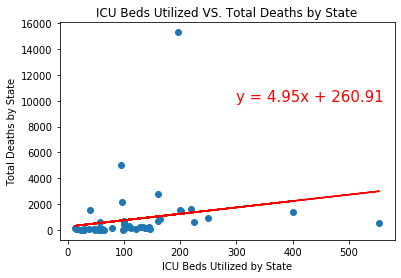

In [77]:
x_values = comb2_df["ICU Beds Utilized"]
y_values = comb2_df["Total Deaths"]
plt.scatter(x_values,y_values)
plt.xlabel("ICU Beds Utilized by State")
plt.ylabel("Total Deaths by State")
plt.title("ICU Beds Utilized VS. Total Deaths by State")


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(300,10000),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("PNG Folder/liz_bedsutilizedvsdeaths.png")

In [79]:
rankpop_df = comb2_df.merge(pop_df,how = 'left',on = "State")
rankpop_df2 = rankpop_df[["State","2019 Pop Est","Overall Rank","Total Deaths"]]
rankpop_df2.sort_values("Overall Rank", inplace=True)
rankpop_df2.reset_index(inplace=True,drop=True)

/Users/lizstevens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The r-squared is: 0.18668919571397113


<function matplotlib.pyplot.show(*args, **kw)>

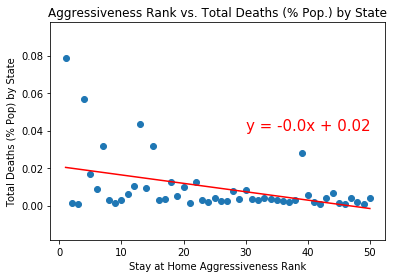

In [81]:
x_values = range(1,51)
y_values = rankpop_df2["Total Deaths"]/rankpop_df2["2019 Pop Est"]*100
labels =rankpop_df2["State"]

plt.scatter(x_values,y_values)
plt.xlabel("Stay at Home Aggressiveness Rank")
plt.ylabel("Total Deaths (% Pop) by State")
plt.title("Aggressiveness Rank vs. Total Deaths (% Pop.) by State")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,.04),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("PNG Folder/stateaggressivescatter.png")
plt.show

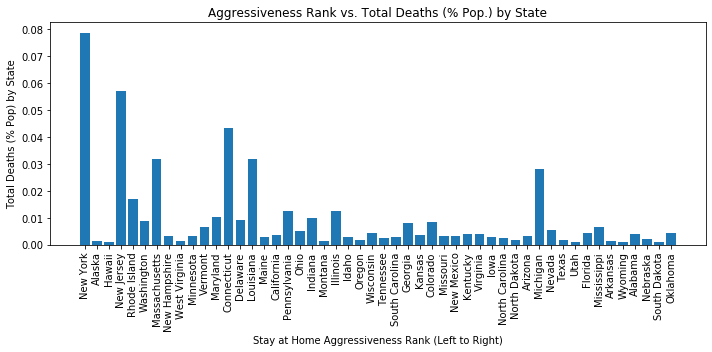

In [82]:
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(x_values,y_values,align="center")
plt.xticks(x_values,labels, rotation='vertical')
plt.xlabel("Stay at Home Aggressiveness Rank (Left to Right)")
plt.ylabel("Total Deaths (% Pop) by State")
plt.title("Aggressiveness Rank vs. Total Deaths (% Pop.) by State")
plt.tight_layout()
plt.savefig("PNG Folder/stateaggressivebar.png")
plt.show()


In [85]:
sorted_rankpop_df = rankpop_df2.sort_values(by='Overall Rank', ascending=True)
sorted_top = sorted_rankpop_df.head(10)
sorted_bottom = sorted_rankpop_df.tail(10)
sorted_total = sorted_rankpop_df.loc[(sorted_rankpop_df['Overall Rank'] <12)|(sorted_rankpop_df['Overall Rank'] >41)]
print(len(sorted_total))

The r-squared is: 0.23041109355952083
20


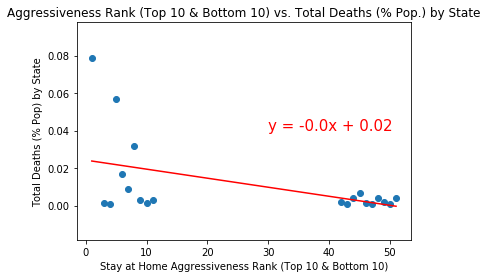

In [87]:
x_values = sorted_total["Overall Rank"]
y_values = sorted_total["Total Deaths"]/sorted_total["2019 Pop Est"]*100

plt.scatter(x_values,y_values)
plt.xlabel("Stay at Home Aggressiveness Rank (Top 10 & Bottom 10)")
plt.ylabel("Total Deaths (% Pop) by State")
plt.title("Aggressiveness Rank (Top 10 & Bottom 10) vs. Total Deaths (% Pop.) by State")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,.04),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.savefig("PNG Folder/lizaggressivetopbottom.png")
print(len(sorted_total))